## Energy minimizer

In [4]:
def plotparticles(rx, ry, rz, rxc, ryc, rzc, title, boxgas=1,):
    figgas = plt.figure()
    ax = figgas.add_subplot(111, projection='3d')

    vectors = {}
    for i in range(len(rx)):
        vectors.update({i: {'point':[rx[i], ry[i], rz[i]], 'color': 'g'}})

    for i in range(len(rxc)):        
        vectors.update({i+.5: {'point':[rxc[i], ryc[i], rzc[i]], 'color': 'r'}})

    for label, props in vectors.items():
        ax.scatter(*props['point'], color=props['color'], alpha=1)

    ax.set_xlim([-.5*boxgas, .5*boxgas])
    ax.set_ylim([-.5*boxgas, .5*boxgas])
    ax.set_zlim([-.5*boxgas, .5*boxgas])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.grid()
    ax.set_title(title)

Step 0: energy=-45.637 boxgas=100.797 boxliq=12.995 totalvol=1026285.695
Step 0: energy_gas=-0.000 energy_liquid=-45.636
Step 100: energy=-1765.136 boxgas=100.859 boxliq=6.589 totalvol=1026285.717
Step 100: energy_gas=-2.017 energy_liquid=-1763.119
Step 200: energy=-2155.974 boxgas=100.861 boxliq=6.179 totalvol=1026285.652
Step 200: energy_gas=-2.566 energy_liquid=-2153.408
Step 300: energy=-2160.464 boxgas=100.861 boxliq=6.183 totalvol=1026285.686
Step 300: energy_gas=-7.125 energy_liquid=-2153.338
Final energy: -2163.3862 Final boxgas: tensor(100.8609, requires_grad=True) Final boxliq: tensor(6.1830, grad_fn=<PowBackward0>)


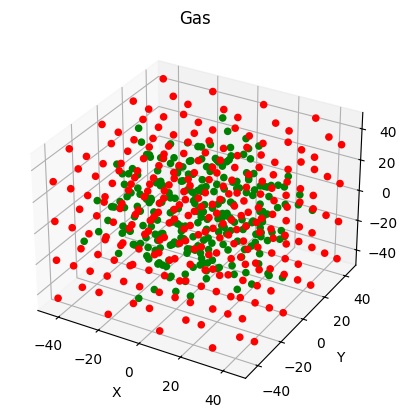

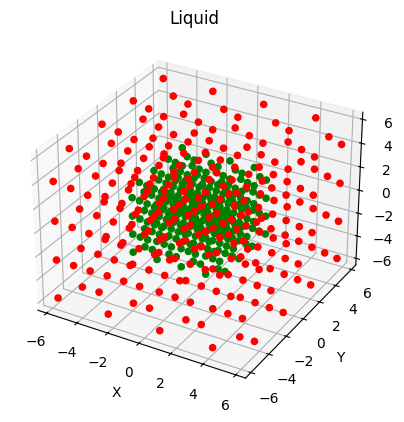

In [84]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import math
import random as rand
#%matplotlib qt
%matplotlib inline

angmax=0.4
anglemu=1.570796327
nc=4
densigas=0.00025
densiliq=0.112
xl=1.338
rmaxgas=1.3
rmaxliq=1.3
rf=1000000000
xmu2=0
qq2=3
temp=0.45
volmax=1
nvol=1
ninser=10000

def get_vector(a, b):
    return [b[0] - a[0], b[1] - a[1], b[2] - a[2]]

def get_scalar_product(a, b):
    return a[0]*b[0]+a[1]*b[1]+a[2]*b[2]

def get_cross_product(a, b):
    return [a[1]*b[2]-a[2]*b[1], a[2]*b[0]-a[0]*b[2], a[0]*b[1]-a[1]*b[0]]

def xnorm(a):
    ad = (a[0]*a[0]+a[1]*a[1]+a[2]*a[2])**0.5
    return [a[0]/ad, a[1]/ad, a[2]/ad]

def vp(a,b):
    c=[a[1]*b[2]-a[2]*b[1],a[2]*b[0]-a[0]*b[2],a[0]*b[1]-a[1]*b[0]]
    return c

def initia():
    global rmaxgas, rmaxliq, vol
    ngas, nliq, n, rxgas, rygas, rzgas, rxliq, ryliq, rzliq, ex, ey, ez, emx, emy, emz = fcc()
    volgas=ngas/densigas
    volliq=nliq/densiliq
    vol=volgas+volliq
    boxgas=volgas**(1./3.)
    boxliq=volliq**(1./3.)
    if boxliq>8:	
        cutliq=4
        cutgas=4
    else:
        cutliq=boxliq/2
        cutgas=boxliq/2 
    cutgas2=cutgas**2
    cutliq2=cutliq**2
    rmaxgas=rmaxgas/boxgas
    rmaxliq=rmaxliq/boxliq
    return ngas, nliq, n, rxgas, rygas, rzgas, rxliq, ryliq, rzliq, ex, ey, ez, emx, emy, emz, boxliq, boxgas, cutgas2, cutliq2

def fcc():
    rroot3=1/np.sqrt(3)
    ngas=4*nc**3
    nliq=4*nc**3
    n = nliq+ngas

    cell  = 1.0 / nc
    cell2 = 0.5 * cell

    rx = [0,0,0,0]
    ry = [0,0,0,0]
    rz = [0,0,0,0]

    ex = [0,0,0,0]
    ey = [0,0,0,0]
    ez = [0,0,0,0]

    emx = [0,0,0,0]
    emy = [0,0,0,0]
    emz = [0,0,0,0]

    #Sublattice A
    rx[0] =  0.0
    ry[0] =  0.0
    rz[0] =  0.0
    ex[0] =  rroot3
    ey[0] =  rroot3
    ez[0] =  rroot3
    if anglemu != 0:
        emx[0] = 0.0
        emy[0] = ez[0]
        emz[0] = -ey[0]
        em=xnorm([emx[0], emy[0], emz[0]])
        emx[0]=em[0]
        emy[0]=em[1]
        emz[0]=em[2]
    else:
        emx[0] = ex[0]
        emy[0] = ez[0]
        emz[0] = ey[0]

    #Sublattice B
    rx[1] =  cell2
    ry[1] =  cell2
    rz[1] =  0.0
    ex[1] =  rroot3
    ey[1] =  -rroot3
    ez[1] =  -rroot3
    if anglemu != 0:
        emx[1] = ez[1]
        emy[1] = 0.0
        emz[1] = -ex[1]
        em=xnorm([emx[1], emy[1], emz[1]])
        emx[1]=em[0]
        emy[1]=em[1]
        emz[1]=em[2]
    else:
        emx[1] = ex[1]
        emy[1] = ez[1]
        emz[1] = ey[1]

    #Sublattice C
    rx[2] =  0.0
    ry[2] =  cell2
    rz[2] =  cell2
    ex[2] =  -rroot3
    ey[2] =  rroot3
    ez[2] =  -rroot3
    if anglemu != 0:
        emx[2] = ey[2]
        emy[2] = -ex[2]
        emz[2] = 0.0
        em=xnorm([emx[2], emy[2], emz[2]])
        emx[2]=em[0]
        emy[2]=em[1]
        emz[2]=em[2]
    else:
        emx[2] = ex[2]
        emy[2] = ez[2]
        emz[2] = ey[2]

    #Sublattice D
    rx[3] =  cell2
    ry[3] =  0.0
    rz[3] =  cell2
    ex[3] =  -rroot3
    ey[3] =  -rroot3
    ez[3] =  rroot3
    if anglemu != 0:
        emx[3] = 0.0
        emy[3] = -ez[3]
        emz[3] = ey[3]
        em=xnorm([emx[3], emy[3], emz[3]])
        emx[3]=em[0]
        emy[3]=em[1]
        emz[3]=em[2]
    else:
        emx[3] = ex[3]
        emy[3] = ez[3]
        emz[3] = ey[3]

    for iz in range(nc):
        for iy in range(nc):
            for ix in range(nc):
                for iref in range(4):
                    rx.append(rx[iref] + cell * (ix))
                    ry.append(ry[iref] + cell * (iy))
                    rz.append(rz[iref] + cell * (iz))
                    ex.append(ex[iref])
                    ey.append(ey[iref])
                    ez.append(ez[iref])
                    emx.append(emx[iref])
                    emy.append(emy[iref])
                    emz.append(emz[iref])
    del rx[:4]
    del ry[:4]
    del rz[:4]
    del ex[:4]
    del ey[:4]
    del ez[:4]
    del emx[:4]
    del emy[:4]
    del emz[:4]

    for i in range(ngas):
        rx[i] = (rx[i]-0.5+(cell2*.5))
        ry[i] = (ry[i]-0.5+(cell2*.5))
        rz[i] = (rz[i]-0.5+(cell2*.5))

    rxgas = rx.copy()
    rygas = ry.copy()
    rzgas = rz.copy()
    rxliq = rx.copy()
    ryliq = ry.copy()
    rzliq = rz.copy()

    return ngas, nliq, n, rxgas, rygas, rzgas, rxliq, ryliq, rzliq, ex, ey, ez, emx, emy, emz

def energy(coordinate_matrix, box, coordinate_matrix_e, coordinate_matrix_em):
    #coordinate_matrix_clone = coordinate_matrix.clone()

    #separation_matrix=torch.tensor([])

    #for _ in range(1, len(coordinate_matrix_clone[1, :])):
    #    sub = coordinate_matrix_clone[:, :1]
    #    coordinate_matrix_clone = coordinate_matrix_clone[:, 1:]
    #    separation_matrix = torch.cat([separation_matrix, coordinate_matrix_clone-sub], axis=1)

    i, j = torch.triu_indices(256, 256, offset=1)
    
    coord_i = coordinate_matrix[:, i]
    coord_j = coordinate_matrix[:, j]
    separation_matrix = coord_i - coord_j

    minimum_image_matrix=separation_matrix-1*torch.round(separation_matrix/1)

#    coordinate_matrix_e1 = coordinate_matrix_e[:, i]
#    coordinate_matrix_e2 = coordinate_matrix_e[:, j]
#    coordinate_matrix_em1 = coordinate_matrix_em[:, i]
#    coordinate_matrix_em2 = coordinate_matrix_em[:, j]
#32640 number of pairwise comparisons
#    for i in range(1):
#        print(coordinate_matrix_e1[0, i], coordinate_matrix_e1[1, i], coordinate_matrix_e1[2, i],coordinate_matrix_e2[0, i], coordinate_matrix_e2[1, i], coordinate_matrix_e2[2, i])
#        print(sdm(box,separation_matrix[0,i],separation_matrix[1,i],separation_matrix[2,i],coordinate_matrix_e1[0, i], coordinate_matrix_e1[1, i], coordinate_matrix_e1[2, i],coordinate_matrix_e2[0, i], coordinate_matrix_e2[1, i], coordinate_matrix_e2[2, i],coordinate_matrix_em1[0, i], coordinate_matrix_em1[1, i], coordinate_matrix_em1[2, i],coordinate_matrix_em2[0, i], coordinate_matrix_em2[1, i], coordinate_matrix_em2[2, i]))

    scaled_matrix = minimum_image_matrix*box
    distance_matrix = (torch.sum(scaled_matrix**2, dim=0, keepdim=True))**0.5
    energy_matrix = ((1/distance_matrix)**12-(1/distance_matrix)**6)*4
    loss = torch.sum(energy_matrix)
    total_distance = torch.sum(distance_matrix)
    return loss, total_distance, distance_matrix, minimum_image_matrix, separation_matrix, energy_matrix, scaled_matrix, box

def main(rxgas, rygas, rzgas, rxliq, ryliq, rzliq, ex, ey, ez, emx, emy, emz, boxgas, boxliq, lr=0.003, iterations=400):
    coordinate_matrix_gas=torch.tensor([rxgas, rygas, rzgas]).requires_grad_()
    boxgas=torch.tensor(boxgas).requires_grad_()
    coordinate_matrix_liq=torch.tensor([rxliq, ryliq, rzliq]).requires_grad_()
    boxliq=torch.tensor(boxliq).requires_grad_()
    coordinate_matrix_e=torch.tensor([ex, ey, ez]).requires_grad_()
    coordinate_matrix_em=torch.tensor([emx, emy, emz]).requires_grad_()

    pointsgas = torch.split(coordinate_matrix_gas, 1, dim=1)
    rxgas, rygas, rzgas = torch.split(coordinate_matrix_gas, 1, dim=0)
    pointsliq = torch.split(coordinate_matrix_liq, 1, dim=1)
    rxliq, ryliq, rzliq = torch.split(coordinate_matrix_liq, 1, dim=0)

    rxgasc=(rxgas.clone().detach().numpy())*(boxgas.clone().detach().numpy())
    rygasc=(rygas.clone().detach().numpy())*(boxgas.clone().detach().numpy())
    rzgasc=(rzgas.clone().detach().numpy())*(boxgas.clone().detach().numpy())
    boxgasc=(boxgas.clone().detach().numpy())

    rxliqc=(rxliq.clone().detach().numpy())*(boxliq.clone().detach().numpy())
    ryliqc=(ryliq.clone().detach().numpy())*(boxliq.clone().detach().numpy())
    rzliqc=(rzliq.clone().detach().numpy())*(boxliq.clone().detach().numpy())
    boxliqc=(boxliq.clone().detach().numpy())

    optimizer = torch.optim.Adam([coordinate_matrix_gas, boxgas, coordinate_matrix_liq], lr=lr, weight_decay=0)

    for i in range(iterations):
        optimizer.zero_grad()
        ug, dg, tg, mg, sg, eg, scaleg, bg =energy(coordinate_matrix_gas, boxgas, coordinate_matrix_e, coordinate_matrix_em)
        ul, dl, tl, ml, sl, el, scalel, bl = energy(coordinate_matrix_liq, (vol-(boxgas**3))**(1/3), coordinate_matrix_e, coordinate_matrix_em)
        u=ul+ug
        u.backward()
        optimizer.step()
        if i % 100 == 0:
            boxliq=(vol-(boxgas**3))**(1/3)
            print(f"Step {i}: energy={u.item():.3f} boxgas={boxgas.item():.3f} boxliq={boxliq.item():.3f} totalvol={(boxgas.item()**3)+(boxliq.item()**3):.3f}")
            print(f"Step {i}: energy_gas={ug:.3f} energy_liquid={ul:.3f}")

    print('Final energy:', u.detach().numpy(), 'Final boxgas:', boxgas, 'Final boxliq:', boxliq)

    pointsgas = torch.split(coordinate_matrix_gas, 1, dim=1)
    rxgas, rygas, rzgas = torch.split(coordinate_matrix_gas, 1, dim=0)
    pointsliq = torch.split(coordinate_matrix_liq, 1, dim=1)
    rxliq, ryliq, rzliq = torch.split(coordinate_matrix_liq, 1, dim=0)

    rxgaso=((rxgas-torch.round(rxgas)).clone().detach().numpy())*(boxgas.clone().detach().numpy())
    rygaso=((rygas-torch.round(rygas)).clone().detach().numpy())*(boxgas.clone().detach().numpy())
    rzgaso=((rzgas-torch.round(rzgas)).clone().detach().numpy())*(boxgas.clone().detach().numpy())

    rxliqo=((rxliq-torch.round(rxliq)).clone().detach().numpy())*(boxliq.clone().detach().numpy())
    ryliqo=((ryliq-torch.round(ryliq)).clone().detach().numpy())*(boxliq.clone().detach().numpy())
    rzliqo=((rzliq-torch.round(rzliq)).clone().detach().numpy())*(boxliq.clone().detach().numpy())

    plotparticles(rxgaso, rygaso, rzgaso, rxgasc, rygasc, rzgasc, 'Gas', boxgasc)

    plotparticles(rxliqo, ryliqo, rzliqo, rxliqc, ryliqc, rzliqc, 'Liquid', boxliqc)

ngas, nliq, n, rxgas, rygas, rzgas, rxliq, ryliq, rzliq, ex, ey, ez, emx, emy, emz, boxliq, boxgas, cutgas2, cutliq2 = initia()

main(rxgas, rygas, rzgas, rxliq, ryliq, rzliq, ex, ey, ez, emx, emy, emz, boxgas, boxliq, 0.003, 400)